# Chapter 4: Deep Convolutional GAN (DCGAN)

In [114]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape,MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam


In [90]:
img_rows = 40
img_cols = 40
channels = 3

img_shape = (img_rows, img_cols, channels)

In [92]:
boxsize = 80
def getImage(image):
    originals=[]
    resizeds=[]
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cur_x=0
    cur_y=0
    comp = False
    while True:
        if comp:
            break
        while True:
            originals.append(img[cur_y:cur_y+boxsize,cur_x:cur_x+boxsize])
            cur_x += boxsize
            if cur_x + boxsize > img.shape[1]:
                cur_x = 0
                cur_y += boxsize
                if cur_y +boxsize > img.shape[0]:
                    comp = True
                break   

    for item in originals:
        dim = (40, 40)
        resized =  cv2.resize(item, dim, interpolation =cv2.INTER_AREA)
        resizeds.append(resized)
    return originals,resizeds


In [93]:
lowres = [] 
highres = []
for file in os.listdir("Cars"):
    joined =  os.path.join("Cars",file)
    x,y = getImage(joined)
    highres.extend(x)
    lowres.extend(y)
highres = np.asarray(highres)
lowres = np.asarray(lowres)


In [94]:
# Rescale [0, 255] pixel values to [-1, 1]
highresscaled = highres / 127.5 - 1.0
lowresscaled = lowres /127.5 - 1.0

In [95]:
print(highres.shape)

(22141, 80, 80, 3)


## Build the Model

In [96]:
def build_super_res(img_shape):

    model = Sequential()
    model.add(Conv2DTranspose(64, kernel_size=5, strides=1, padding='same',input_shape=img_shape, kernel_initializer='lecun_uniform',bias_initializer='lecun_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(32, kernel_size=5, strides=2, padding='same',input_shape=img_shape, kernel_initializer='lecun_uniform',bias_initializer='lecun_uniform'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(3, kernel_size=3, strides=1, padding='same' , kernel_initializer='lecun_uniform',bias_initializer='lecun_uniform'))
    model.add(Activation('tanh'))

    return model

In [97]:
# Build and compile the superRez
superz = build_super_res(img_shape)
superz.compile(loss='mean_absolute_error',optimizer=Adam(),metrics=['accuracy'])

In [98]:
superz.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_13 (Conv2DT (None, 40, 40, 64)        4864      
_________________________________________________________________
batch_normalization_8 (Batch (None, 40, 40, 64)        256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 80, 80, 32)        51232     
_________________________________________________________________
batch_normalization_9 (Batch (None, 80, 80, 32)        128       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 80, 80, 3)         867       
__________

## Training

In [99]:
def train(iterations, batch_size, sample_interval):

    train_full, test_full, train_low, test_low = train_test_split(highresscaled,lowresscaled , test_size=0.2)
    for iteration in range(iterations):
        idx = np.random.randint(0, train_full.shape[0], batch_size)
        full = train_full[idx]
        low = train_low[idx]
        idtest = np.random.randint(0, test_full.shape[0], batch_size//4)
        fullt = test_full[idtest]
        lowt = test_low[idtest]
        loss = superz.train_on_batch(low, full)
        if (iteration + 1) % sample_interval == 0:
            loss_test = superz.test_on_batch(lowt, fullt)
            print('itearation:{} loss train:{}  loss test:{}'.format(iteration,loss,loss_test))

In [100]:
def trainfit():
     train_full, test_full, train_low, test_low = train_test_split(highresscaled,lowresscaled , test_size=0.2)
     superz.fit(train_low, train_full, validation_data=(test_low, test_full), epochs=20000, batch_size=50, verbose=2,callbacks=[tensorboard_callback])

In [105]:
train(20000,300,1000)

999
loss real [0.04785284, 0.7243281]
loss test [0.059942972, 0.7605938]
1999
loss real [0.04015724, 0.77814376]
loss test [0.03918987, 0.7633625]
2999
loss real [0.03728451, 0.78002083]
loss test [0.03399848, 0.7760875]
3999
loss real [0.034964096, 0.81290156]
loss test [0.042047665, 0.78310627]
4999
loss real [0.04116608, 0.7907771]
loss test [0.033859774, 0.7714667]
5999
loss real [0.03234299, 0.8199302]
loss test [0.02939356, 0.85903543]
6999
loss real [0.029744262, 0.79162294]
loss test [0.031531468, 0.8067896]
7999
loss real [0.0394947, 0.86985]
loss test [0.030327434, 0.80282706]
8999
loss real [0.029299488, 0.89025366]
loss test [0.02723612, 0.88018125]
9999
loss real [0.031571645, 0.8537182]
loss test [0.033083078, 0.84508955]


KeyboardInterrupt: 

In [34]:
trainfit()

Train on 17712 samples, validate on 4429 samples
Epoch 1/20000
 - 14s - loss: 89.4047 - acc: 0.3230 - val_loss: 89.7484 - val_acc: 0.3168
Epoch 2/20000
 - 13s - loss: 89.3615 - acc: 0.3159 - val_loss: 89.7481 - val_acc: 0.3236
Epoch 3/20000
 - 13s - loss: 89.3615 - acc: 0.3226 - val_loss: 89.7481 - val_acc: 0.3293
Epoch 4/20000
 - 13s - loss: 89.3614 - acc: 0.3299 - val_loss: 89.7481 - val_acc: 0.3363
Epoch 5/20000
 - 13s - loss: 89.3614 - acc: 0.3316 - val_loss: 89.7481 - val_acc: 0.3301
Epoch 6/20000
 - 13s - loss: 89.3614 - acc: 0.3285 - val_loss: 89.7481 - val_acc: 0.3293


KeyboardInterrupt: 

16894


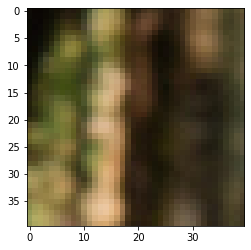

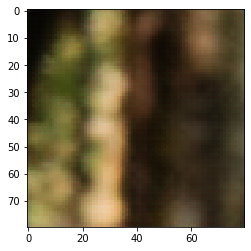

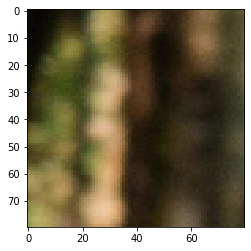

16895


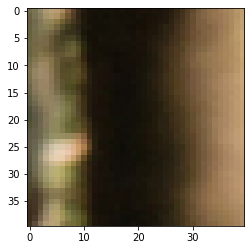

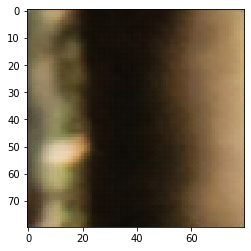

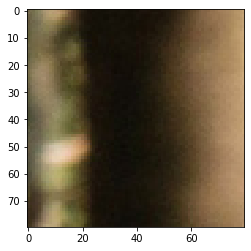

In [106]:
start, end =16894,16896
yyy = lowres[start:end]
lowresscaled = yyy /127.5 - 1.0
gen_imgs= superz.predict(lowresscaled)
gen_imgs = 0.5 * gen_imgs + 0.5
j=0
for i in range(start,end):
    print(i)
    plt.imshow(lowres[i])
    plt.show()
    plt.imshow(gen_imgs[j])
    j+=1
    plt.show()
    plt.imshow(highres[i])
    plt.show()
